In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# # Import Drive API and authenticate.
# from google.colab import drive

# # Mount your Drive to the Colab VM.
# drive.mount('/content/drive')




In [3]:
path = "../data/players_stats_salary.csv"
df= pd.read_csv(path)
df.shape

(705, 92)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               524 non-null    float64
 1   Unnamed: 0_x             705 non-null    int64  
 2   fb_id                    705 non-null    object 
 3   player_name              705 non-null    object 
 4   Squad_from_op            705 non-null    object 
 5   Opposing_Poss            705 non-null    float64
 6   Opposing_Touches         705 non-null    int64  
 7   Nation                   705 non-null    object 
 8   Position                 705 non-null    object 
 9   Nineties                 705 non-null    float64
 10  xA                       705 non-null    float64
 11  Key_pass                 705 non-null    int64  
 12  Comp_prog                705 non-null    float64
 13  Total_Cmp                705 non-null    int64  
 14  Total_Att                7

1. DATA PROFILES — PLOTS AND TABLES
Reviewing summary statistics
Summary statistics can be evaluated via a summary statistics table and by checking the individual variable distribution plots. Both will indicate the spread of your data. Depending on the distribution, you may be able to infer the mean from distribution plots; however, the summary table is the best way to review this value. Compare the example summary statistics table and the histogram plots for reference.

In [6]:
df['Squad_from_op'].value_counts()

Toronto FC          30
Atlanta Utd         30
Los Angeles FC      28
FC Cincinnati       28
Portland Timbers    28
D.C. United         28
Houston Dynamo      28
Orlando City        27
Nashville           27
Inter Miami         26
LA Galaxy           26
Vancouver           26
Minnesota Utd       26
Seattle             26
CF Montréal         26
FC Dallas           26
Austin FC           26
NYCFC               26
Philadelphia        26
Columbus Crew       25
Chicago Fire        24
Sporting KC         24
Colorado Rapids     24
Real Salt Lake      24
NY Red Bulls        24
San Jose            23
New England         23
Name: Squad_from_op, dtype: int64

In [7]:
SJ = df[df['Squad_from_op'] == 'San Jose']
SJ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 26 to 650
Data columns (total 92 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               17 non-null     float64
 1   Unnamed: 0_x             23 non-null     int64  
 2   fb_id                    23 non-null     object 
 3   player_name              23 non-null     object 
 4   Squad_from_op            23 non-null     object 
 5   Opposing_Poss            23 non-null     float64
 6   Opposing_Touches         23 non-null     int64  
 7   Nation                   23 non-null     object 
 8   Position                 23 non-null     object 
 9   Nineties                 23 non-null     float64
 10  xA                       23 non-null     float64
 11  Key_pass                 23 non-null     int64  
 12  Comp_prog                23 non-null     float64
 13  Total_Cmp                23 non-null     int64  
 14  Total_Att                2

In [52]:
df['Base Salary'] = df['Base Salary'].str.replace('$','')
df['Base Salary'] = df['Base Salary'].str.replace(',','')
df['Base Salary'][0:4]

<ipython-input-52-349d5dd37bb6>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Base Salary'] = df['Base Salary'].str.replace('$','')


0    2750000.00
1     705000.00
2     750000.00
3           NaN
Name: Base Salary, dtype: object

In [53]:

df['Base Salary'] = pd.to_numeric(df['Base Salary'])
df[['Base Salary','Guaranteed Compensation']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Base Salary              524 non-null    float64
 1   Guaranteed Compensation  524 non-null    object 
dtypes: float64(1), object(1)
memory usage: 11.1+ KB


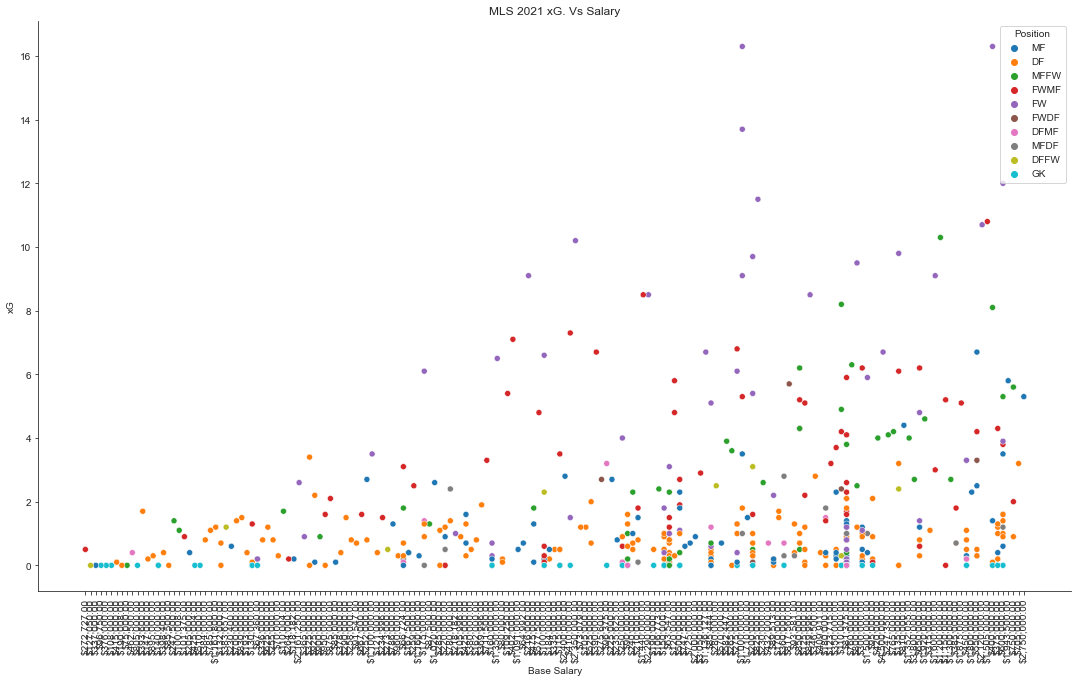

In [29]:
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

plt.gca().invert_xaxis()
plt.xticks(rotation = 90)
g = sns.scatterplot(data=df, x ='Base Salary', y='xG',hue='Position',
                    ax=ax).set(title='MLS 2021 xG. Vs Salary')
sns.despine()




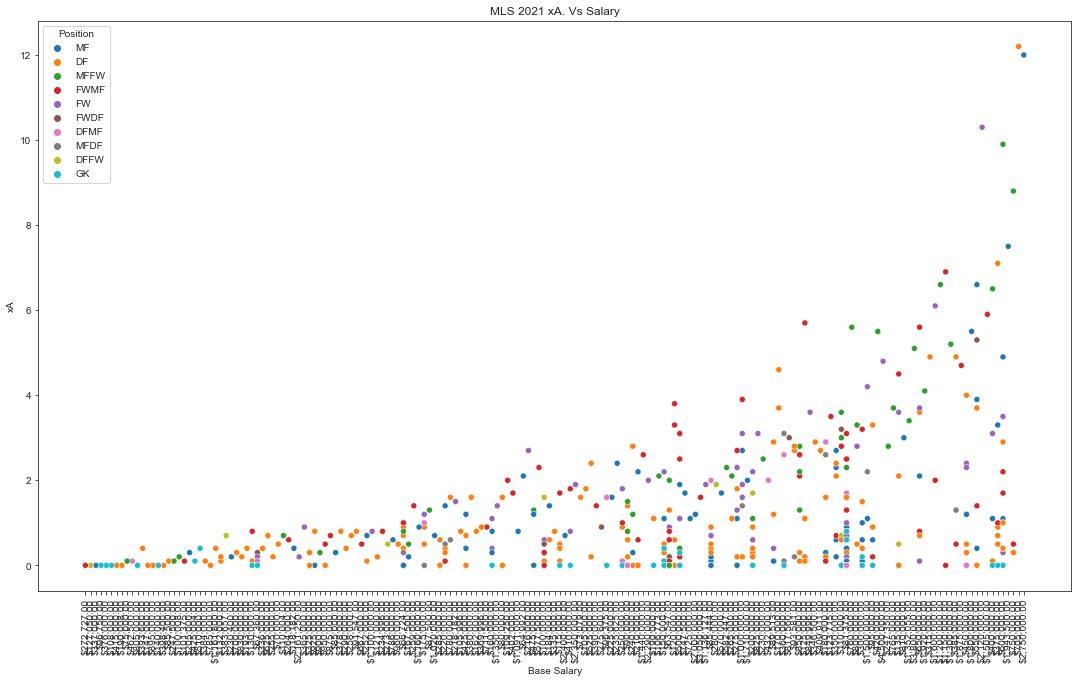

In [33]:
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

plt.gca().invert_xaxis()
plt.xticks(rotation = 90)

g = sns.scatterplot(data=df, x ='Base Salary', y='xA',hue='Position',
                ax=ax).set(title='MLS 2021 xA. Vs Salary')

# plt.tight_layout()

<AxesSubplot:xlabel='Position', ylabel='Base Salary'>

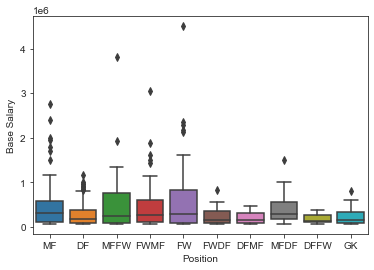

In [54]:
sns.boxplot(x ='Position', y='Base Salary',data=df)

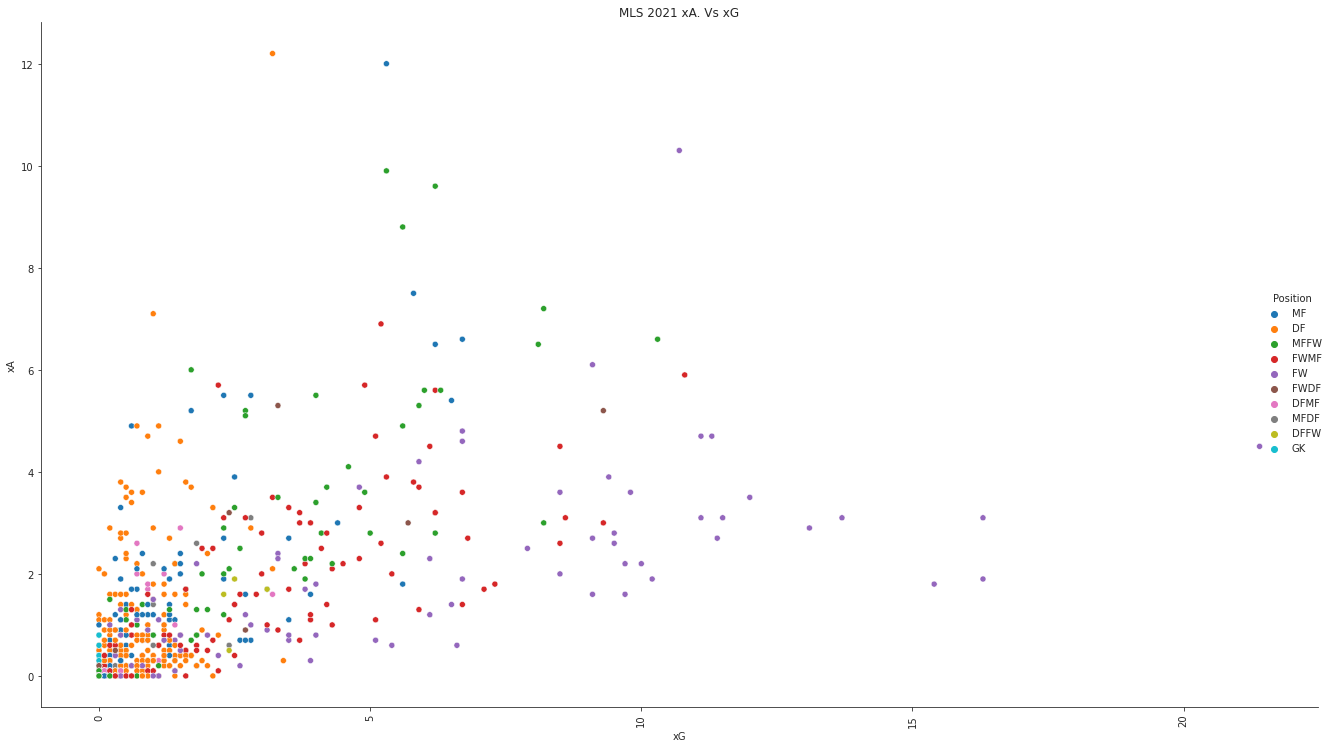

In [ ]:
sns.set_style('ticks')

g = sns.relplot(data=df, x ='xG', y='xA',hue='Position').set(title='MLS 2021 xA. Vs xG')
g.figure.set_size_inches(18.5, 10.5)
sns.despine()
# for ax in g.axes[0]:
#     ax.invert_xaxis()

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.tight_layout()

In [ ]:
df.columns.tolist()

['Unnamed: 0',
 'fb_id',
 'player_name',
 'Squad_from_op',
 'Opposing_Poss',
 'Opposing_Touches',
 'Nation',
 'Position',
 'Nineties',
 'xA',
 'Key_pass',
 'Comp_prog',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp_pct',
 'Total_Tot_Dist',
 'Total_Prg_Dist',
 'Short_Cmp',
 'Short_Att',
 'Short_Cmp_pct',
 'Medium_Cmp',
 'Medium_Att',
 'Medium_Cmp_pct',
 'Long_Cmp',
 'Long_Att',
 'Long_Cmp_pct',
 'touches',
 'touches_def_box',
 'touches_def_3rd',
 'touches_mid_3rd',
 'touches_att_3rd',
 'touches_att_box',
 'touch_live',
 'dribble_Succ',
 'dribble_Att',
 'dribble_Succ_pct',
 'num_dribble_past',
 'dribble_megs',
 'carries',
 'carries_dist',
 'carries_prog_dist',
 'carries_prog',
 'carries_att_3rd',
 'carries_att_box',
 'miss_control',
 'dispossed',
 'recep_targ',
 'recep_succ',
 'recept_pct',
 'Yellow_cards',
 'Red_cards',
 'Second_yellow',
 'Fouls',
 'Fouls_drawn',
 'Offsides',
 'Crosses',
 'def_interceptions',
 'from_mish_tackles_won',
 'PK_won',
 'PK_conceded',
 'OG',
 'Recoveries',
 'Aerial_

In [ ]:
df.head()

,Unnamed: 0,fb_id,player_name,Squad_from_op,Opposing_Poss,Opposing_Touches,Nation,Position,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,Short_Att,Short_Cmp_pct,Medium_Cmp,Medium_Att,Medium_Cmp_pct,Long_Cmp,Long_Att,Long_Cmp_pct,touches,touches_def_box,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_box,touch_live,dribble_Succ,dribble_Att,dribble_Succ_pct,num_dribble_past,dribble_megs,carries,carries_dist,carries_prog_dist,carries_prog,carries_att_3rd,carries_att_box,miss_control,dispossed,recep_targ,recep_succ,recept_pct,Yellow_cards,Red_cards,Second_yellow,Fouls,Fouls_drawn,Offsides,Crosses,def_interceptions,from_mish_tackles_won,PK_won,PK_conceded,OG,Recoveries,Aerial_Duels_lost,Aerial_win_pct
0,0,11c30a46,Carles Gil,New England,49.1,20024,es ESP,MF,25.4,12.0,134,277.0,1240,1669,74.3,25809,9931,444,511,86.9,535,652,82.1,244,451,54.1,1925,7,129,966,1004,102,1671,66,98,67.3,67,8,1438,9798,5239,276,110,29,50,44,1688,1437,85.1,168,0,0,7,76,0,114,23,4,0,0,0,164,4,17.4
1,1,acd47bc0,Julian Gressel,D.C. United,54.0,20526,de GER,DF,29.9,12.2,96,166.0,1116,1732,64.4,24290,10948,415,523,79.3,475,618,76.9,222,530,41.9,2021,58,378,916,834,85,1569,16,37,43.2,17,1,1055,5443,3503,171,38,17,24,25,1300,1091,83.9,113,0,0,35,24,4,144,68,19,0,0,0,251,30,44.8
2,2,614b26e3,Emanuel Reynoso,Minnesota Utd,49.9,20887,ar ARG,MFFW,26.5,8.8,91,234.0,1116,1618,69.0,20799,7764,529,636,83.2,385,522,73.8,174,382,45.5,2162,5,143,1016,1177,83,1948,107,193,55.4,112,17,1668,7466,4081,255,73,14,108,95,1856,1590,85.7,225,1,0,58,107,2,69,27,43,1,0,0,198,18,28.6
3,3,0adeafaa,Albert Rusnák,Real Salt Lake,49.1,19279,sk SVK,MFFW,33.8,7.2,87,145.0,1377,1647,83.6,28368,7668,553,605,91.4,542,596,90.9,263,409,64.3,1894,20,241,995,806,107,1629,28,41,68.3,28,5,1288,7702,3905,210,74,28,37,31,1522,1314,86.3,157,0,0,23,33,1,46,25,16,0,0,0,203,4,12.9
4,4,f99f37fc,Maximiliano Moralez,NYCFC,46.5,19332,ar ARG,MFFW,26.5,9.6,83,205.0,1234,1654,74.6,24667,8427,554,635,87.2,398,505,78.8,255,424,60.1,1977,7,159,1078,840,108,1781,20,32,62.5,21,2,1310,5979,2654,157,45,12,47,53,1830,1473,80.5,225,1,0,45,68,5,70,23,26,0,0,0,167,10,23.3


In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


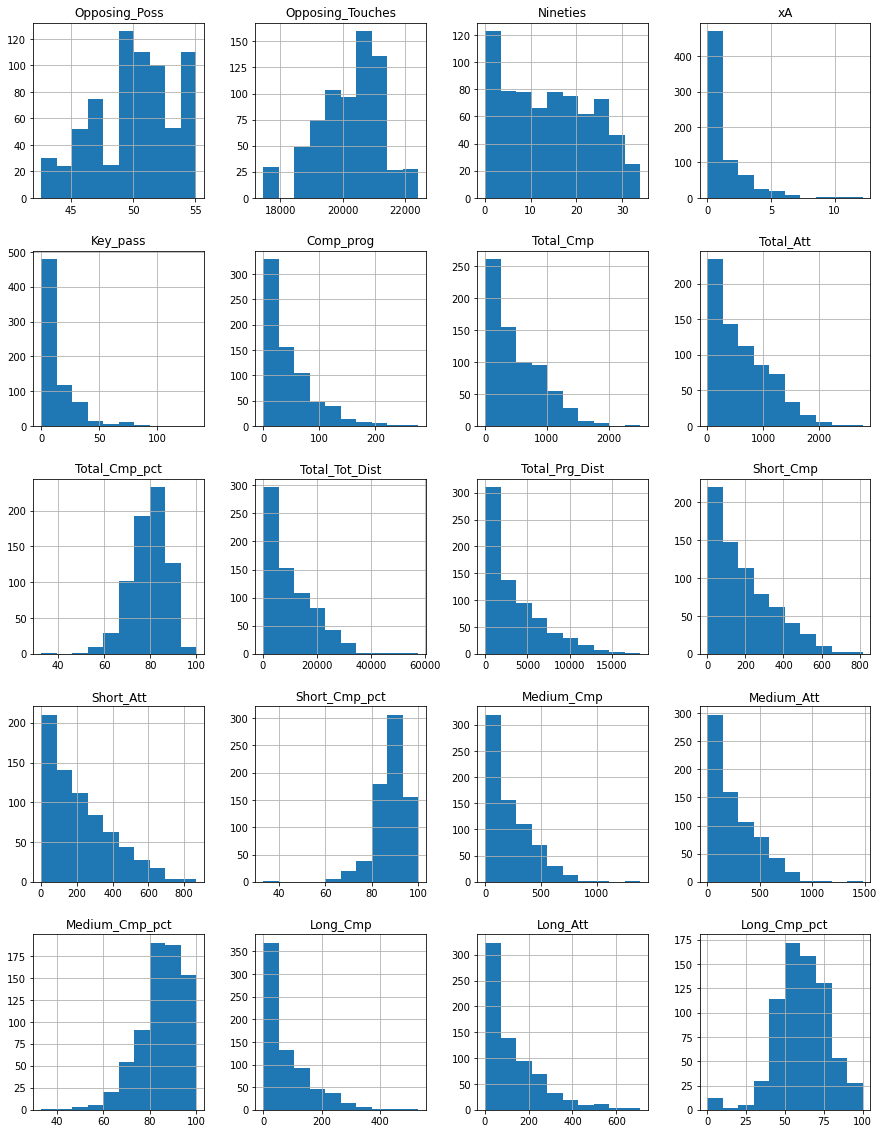

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
hist = df[['player_name',
 'Squad_from_op',
 'Opposing_Poss',
 'Opposing_Touches',
 'Nation',
 'Position',
 'Nineties',
 'xA',
 'Key_pass',
 'Comp_prog',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp_pct',
 'Total_Tot_Dist',
 'Total_Prg_Dist',
 'Short_Cmp',
 'Short_Att',
 'Short_Cmp_pct',
 'Medium_Cmp',
 'Medium_Att',
 'Medium_Cmp_pct',
 'Long_Cmp',
 'Long_Att',
 'Long_Cmp_pct']].hist(bins=10, ax=ax )


no guasian distributions observed in passing features. 
passing attempt features have distinctly right tailed data and are skewed to the left,
 and passing pct features have left tails and are skewed to the right.

 Both of these observations are to be expected in the data as only few players will have a large amount of the different kind of attempts 
 and there is a basic threshold for completion percentage among players in the league. 

 There looks to be over 100 players who have zero 90's, meaning they did not play and may not be useful for clustering, Will leave them in to see if they are grouped toeather by DBscan, 


 when comparing the completion pct features long comp pct is the closest to normal and there are few players at the high completion percentages while there is more players at the top end of completion pct for short and medium pct due to dificulty of long pass completions and volume of long balls compared to short. 

 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


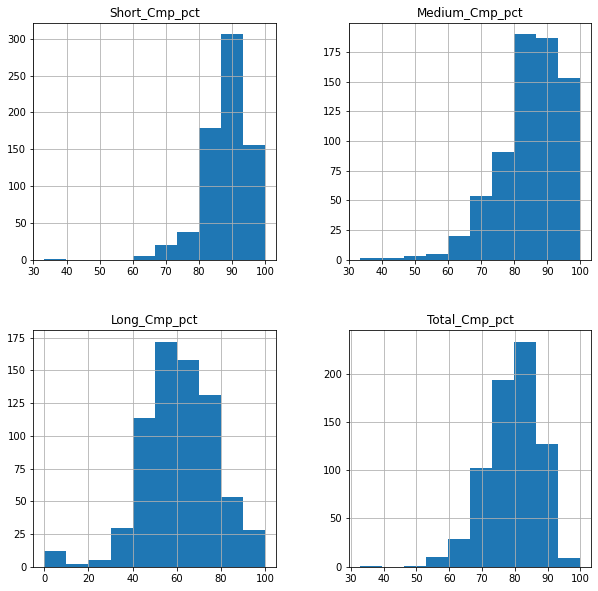

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
hist = df[['Short_Cmp_pct','Medium_Cmp_pct','Long_Cmp_pct','Total_Cmp_pct']].hist(bins=10,ax=ax)
plt.show()

In [ ]:
df.corr().style.background_gradient(cmap="GnBu")

In [ ]:
passes = df[[
 'Opposing_Poss',
 'Opposing_Touches',
 'Nation',
 'Position',
 'xA',
 'Key_pass',
 'Comp_prog',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp_pct',
 'Total_Tot_Dist',
 'Total_Prg_Dist',
 'Short_Cmp',
 'Short_Att',
 'Short_Cmp_pct',
 'Medium_Cmp',
 'Medium_Att',
 'Medium_Cmp_pct',
 'Long_Cmp',
 'Long_Att',
 'Long_Cmp_pct']]

In [ ]:
passes.corr().style.background_gradient(cmap="GnBu")

,Opposing_Poss,Opposing_Touches,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,Short_Att,Short_Cmp_pct,Medium_Cmp,Medium_Att,Medium_Cmp_pct,Long_Cmp,Long_Att,Long_Cmp_pct
Opposing_Poss,1.000000,0.861667,-0.037485,-0.036718,-0.036013,-0.116345,-0.093634,-0.209210,-0.101438,-0.046469,-0.122065,-0.110113,-0.081531,-0.115709,-0.101642,-0.150260,-0.065063,-0.030309,-0.091571
Opposing_Touches,0.861667,1.000000,-0.029975,-0.042056,-0.013715,-0.076677,-0.064213,-0.122260,-0.076446,-0.032745,-0.066076,-0.059164,-0.039810,-0.078837,-0.069588,-0.103508,-0.067657,-0.044513,-0.068666
xA,-0.037485,-0.029975,1.000000,0.944777,0.639348,0.394264,0.457065,-0.182752,0.293731,0.194020,0.577948,0.614846,-0.256317,0.262696,0.326144,-0.275793,0.176244,0.238804,-0.085666
Key_pass,-0.036718,-0.042056,0.944777,1.000000,0.737601,0.486821,0.544450,-0.123254,0.384861,0.269556,0.661966,0.692021,-0.200898,0.351182,0.411998,-0.224922,0.260451,0.316175,-0.058812
Comp_prog,-0.036013,-0.013715,0.639348,0.737601,1.000000,0.843970,0.863266,0.169391,0.760258,0.612956,0.892165,0.900046,-0.020465,0.770289,0.812433,0.001800,0.595379,0.565797,0.118554
Total_Cmp,-0.116345,-0.076677,0.394264,0.486821,0.843970,1.000000,0.992411,0.331611,0.974649,0.850139,0.909461,0.894345,0.199495,0.977950,0.985550,0.246529,0.848800,0.790247,0.213685
Total_Att,-0.093634,-0.064213,0.457065,0.544450,0.863266,0.992411,1.000000,0.251434,0.966998,0.865971,0.915956,0.906375,0.168702,0.957078,0.973333,0.206092,0.846222,0.815974,0.161008
Total_Cmp_pct,-0.209210,-0.122260,-0.182752,-0.123254,0.169391,0.331611,0.251434,1.000000,0.311134,0.150857,0.258032,0.221780,0.492457,0.384524,0.345002,0.526453,0.232883,0.078106,0.585816
Total_Tot_Dist,-0.101438,-0.076446,0.293731,0.384861,0.760258,0.974649,0.966998,0.311134,1.000000,0.920317,0.801238,0.781209,0.262107,0.976564,0.971314,0.324043,0.942298,0.889878,0.215465
Total_Prg_Dist,-0.046469,-0.032745,0.194020,0.269556,0.612956,0.850139,0.865971,0.150857,0.920317,1.000000,0.641768,0.620342,0.329505,0.855832,0.849245,0.354631,0.927464,0.949695,0.081958


Expected Assists and short completions and sort attempts have a positive corelation of 0.58	and 0.61 respectivly. 
interestinly xA and short comp percent have .25 % negative correlation, this could point to trying to slot lots of short passes into dangerous areas that may not always be completed results in more expected assists than just lots of completed short passes that do not create shoring changes. Other features correlation to xA and xG can be followed up. 

In [ ]:
#summary stats table transposed for df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Opposing_Poss,705.0,49.975887,3.217665,42.6,47.4,50.200000,51.9,55.1
Opposing_Touches,705.0,20231.557447,1045.379029,17449.0,19640.0,20180.000000,21096.0,22416.0
Nineties,705.0,14.184397,9.490666,0.1,5.7,13.800000,22.2,34.0
xA,705.0,1.271773,1.712955,0.0,0.1,0.600000,1.8,12.2
Key_pass,705.0,12.395745,16.070627,0.0,1.0,6.000000,18.0,134.0
Comp_prog,705.0,43.565957,44.457608,0.0,7.0,32.000000,64.0,277.0
Total_Cmp,705.0,498.785816,415.759803,3.0,143.0,403.000000,796.0,2514.0
Total_Att,705.0,616.339007,495.151713,5.0,189.0,515.000000,966.0,2777.0
Total_Cmp_pct,705.0,79.308652,8.020395,32.7,74.6,80.300000,85.2,100.0
Total_Tot_Dist,705.0,10004.109220,8841.479791,59.0,2591.0,7437.000000,15718.0,57636.0


In [ ]:
#summary stats table transposed for df
df.describe().T


hist = df.hist(bins=30, figsize=(10,10)


# workflow for catagorecial variables 
df_cat = df.select_dtypes(include='object').copy()

df_cat.col.value_counts()

sns.countplot(data=df_cat,x='colname')

#use boxplot to observe outliers - key for anamoly dection 

boxplot = df.boxplot(grid = False,vert=False,fontsize=15)



2. DATA RELATIONSHIPS
Investigating variable relationships through covariance matrices and other analysis methods is essential for not only evaluating the planned modeling strategy but also allows you to understand your data further. Below, we calculated the correlation coefficients for each variable in the data frame and then fed those correlations into a heatmap for ease of interpretation

In [ ]:
corr = df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# ax = df.plot(kind='scatter',x='x',y='y')
# df[['x','y','lbl']].apply(lambda row: ax.text(*row),axis=1);

ax = df1.plot(kind='scatter',x='win/90', y ='GD' )
df1[['win/90','GD' ,'Squad']].apply(lambda row: ax.text(*row),axis=1)

In [ ]:
## viz group by columns 

spm.reindex(index=spm.mean(axis=1).sort_values(ascending=False).index).plot(
kind='barh',figsize=(10,10))
plt.xlabel('Price')


In [ ]:
# bin a couple feature 


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
df['Key_pass'].value_counts().plot(kind='barh', ax=ax[0])
#Give the plot a helpful title of 'Region'
ax[0].set_title('key passes')
#Label the xaxis 'Count'
ax[0].set_xlabel('Count')
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
df['PK_conceded'].value_counts().plot(kind='barh',ax=ax[1])
#Give the plot a helpful title of 'state'
ax[1].set_title('pk_conceded ')
#Label the xaxis 'Count'
ax[1].set_xlabel('Count')
#Give the subplots a little "breathing room" with a wspace of 0.5
plt.subplots_adjust(wspace=.5);

In [ ]:
2.6.3.5.2 Distribution of weekday and weekend price by state
Next, you can transform the data into a single column for price with a new categorical column that represents the ticket type.

#Code task 15#
#Use the pd.melt function, pass in the ski_data columns 'state', 'AdultWeekday', and 'Adultweekend' only,
#specify 'state' for `id_vars`
#gather the ticket prices from the 'Adultweekday' and 'AdultWeekend' columns using the `value_vars` argument,
#call the resultant price column 'Price' via the `value_name` argument,
#name the weekday/weekend indicator column 'Ticket' via the `var_name` argument
ticket_prices = pd.melt(ski_data[['state','AdultWeekday','AdultWeekend']], 
                        id_vars='state',
              var_name='Ticket',
              value_vars=['AdultWeekday','AdultWeekend'],
              value_name='Price')



This is now in a format we can pass to seaborn's boxplot function to create boxplots of the ticket price distributions for each ticket type for each state.

#Code task 16#
#Create a seaborn boxplot of the ticket price dataframe we created above,
#with 'state' on the x-axis, 'Price' as the y-value, and a hue that indicates 'Ticket'
#This will use boxplot's x, y, hue, and data arguments.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='state', y='Price', hue='Ticket', data=ticket_prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

In [ ]:
plt.figure(10,12)
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu"annot=True)
plt.yticks(rotation=0)


# can also look at variable distributions and correlations with pairplots

g = sns.pairplot(df)



3. IDENTIFYING AND CREATING FEATURES
Variables and features are almost synonymous. The primary difference tends to be the context in which they are used; in machine learning, it is common practice to identify predictive features in your data whereas in parametric statistics, features are often referred to as variables and variables can include the response variable which you predict with your model.

The goal of identifying features is to use your exploratory work to isolate features that will be most helpful in constructing a predictive model. In addition to recognizing those features, it often behooves one to create additional features for inclusion in your predictive modeling work.
Once you have identified the critical features for your model development, you may realize you need to create additional features to augment your original data. You can do this through the development of combining features or revaluing them to emphasize specific relationships. Additional features can also be created through Principal Components Analysis or Clustering.

Building a Principle Components Analysis (PCA) is a useful way to apply a dimension reduction application to identify which features contain the most amount of variation within your development dataset. The predictive model can be constructed on the principal components themselves as features, resulting in feature reduction. Feature reduction is helpful when your data set has too many features to choose from, and you need a more automated way to reduce the number of input features for modeling. There are different flavors of dimension reduction methods based on multi-dimensional scaling, such as Principal Coordinate Analysis. Lasso regression is another tool for a semi-automated feature selection approach. Review these methods to determine the best strategy for your project.


Clustering (e.g. K-means clustering) is an excellent exploratory analysis method for creating additional features which in this case would be the clusters themselves. The clusters can be used in conjunction with additional features if you find them to be valid after review.

## objectives part 3 

1 - adjust position values to basic groups to use to split df for clustering

2-convert player season data to per 90 stats to adjust for different amounts of games played per player.

3- create possesion adjusted stats for defensive KPIs to better show defenders metrics 

In [ ]:
#check number of each position 
df['Pos'].value_counts()

DF      226
MF      115
FWMF     98
FW       85
MFFW     65
GK       65
DFMF     19
MFDF     13
FWDF     10
DFFW      9
Name: Pos, dtype: int64

In [ ]:
pos_lis = df['Pos'].unique()
pos_lis

array(['MF', 'DF', 'MFFW', 'FWMF', 'FW', 'FWDF', 'DFMF', 'MFDF', 'DFFW',
       'GK'], dtype=object)

In [ ]:
## problem - positions like left wing , attacking mid, defensive mid , center back not given - columns filled with unclear values

# solution- remap values to clear basic over arching position values - other features will be used to cluster players on

# technique - iterate over unique position values and clean up into 3 categories as initial mixed up values not descriptive enough to keep

for i in pos_lis:
  if i in ['FWMF','MFFW','MFDF','DFMF']:
    df['Pos'] = df['Pos'].str.replace(i,'MF')

  if i in ['FWDF', 'DFFW']:
    df['Pos'] = df['Pos'].str.replace(i,'FW')
    
df['Pos'].value_counts()

MF    310
DF    226
FW    104
GK     65
Name: Pos, dtype: int64

## objective -2 adjust season stats to per ninety stats for accurate stat comparison.

In [ ]:
def per_90(cols,df):
  """ take season values and adjust to per 90s played by player stats"""
  for col in cols:
    # print(col)
    # print(df[col].mean())
    df[col] = df[col]/df['Nineties']
  
  return(df)

In [ ]:
## create list of columns to be adjusted to per 90 stats
cols =  [
         # this needs to be done on by teams 90's 'Opposing_Touches',
'xA','Key_pass','Comp_prog','Total_Cmp','Total_Att','Total_Tot_Dist','Total_Prg_Dist','Short_Cmp','Short_Att','Medium_Cmp','Medium_Att','Long_Cmp','Long_Att',
'touches','touches_def_box','touches_def_3rd','touches_mid_3rd','touches_att_3rd','touches_att_box','touch_live','dribble_Succ','dribble_Att',
'num_dribble_past','dribble_megs','carries','carries_dist','carries_prog_dist','carries_prog','carries_att_3rd','carries_att_box','miss_control','dispossed','recep_targ',
'recep_succ','Yellow_cards','Red_cards','Second_yellow','Fouls','Fouls_drawn','Offsides','Crosses','def_interceptions','from_mish_tackles_won','PK_won','PK_conceded','OG',
'Recoveries','Aerial_Duels_lost','Gls','Sh','SoT','Sh/90','SoT/90','G/Sh','G/SoT','Dist','FK','PK','PKatt', 'xG','npxG','npxG/Sh','G-xG','np:G-xG']

In [ ]:
# df9 = df.copy()
df =  per_90(cols,df)
df[['player_name','Opposing_Touches','xA','Key_pass','Comp_prog','Total_Cmp','Total_Att']].head(3)

,player_name,Opposing_Touches,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att
0,Carles Gil,20024,0.472441,5.275591,10.905512,48.818898,65.708661
1,Julian Gressel,20526,0.408027,3.210702,5.551839,37.324415,57.926421
2,Emanuel Reynoso,20887,0.332075,3.433962,8.830189,42.113208,61.056604


check to confirm the new df has per 90 stats instead of season totals 

In [ ]:
df.loc[df['player_name']=='Paxten Aaronson']

,Unnamed: 0,Unnamed: 0_x,fb_id,player_name,Squad_from_op,Opposing_Poss,Opposing_Touches,Nation,Position,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,Short_Cmp,Short_Att,Short_Cmp_pct,Medium_Cmp,Medium_Att,Medium_Cmp_pct,Long_Cmp,Long_Att,Long_Cmp_pct,touches,touches_def_box,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_box,touch_live,dribble_Succ,dribble_Att,dribble_Succ_pct,num_dribble_past,dribble_megs,carries,...,Second_yellow,Fouls,Fouls_drawn,Offsides,Crosses,def_interceptions,from_mish_tackles_won,PK_won,PK_conceded,OG,Recoveries,Aerial_Duels_lost,Aerial_win_pct,Pos,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Unnamed: 0_y,First Name,Last Name,Club,Position(s),Base Salary,Guaranteed Compensation,name,_merge
286,3.0,286,4cd41883,Paxten Aaronson,Philadelphia,51.8,20563,us USA,MFFW,6.6,0.19697,1.515152,2.575758,21.666667,29.393939,73.7,323.484848,93.181818,11.666667,14.393939,81.1,8.333333,11.212121,74.3,1.060606,1.969697,53.8,42.727273,0.454545,6.060606,16.515152,22.575758,5.909091,41.969697,1.363636,3.636364,37.5,1.515152,0.30303,31.363636,...,0.0,0.757576,0.757576,0.454545,1.969697,0.757576,1.363636,0.0,0.0,0.0,7.727273,0.757576,27.8,MF,0.454545,1.666667,1.363636,81.8,0.251515,0.204545,0.040909,0.05,2.545455,0.0,0.0,0.0,0.19697,0.19697,0.018182,0.257576,0.257576,3.0,Paxten,Aaronson,Philadelphia Union,M,"$87,500.00","$91,500.00",Paxten Aaronson,both


##objective - 3 - create possesion adjusted metrics , " pAdj "

using stat per 1000 opponent touches as scale to create pAdj stat 
ex: tackles per 1000 opponent touches instead of just tackles per 90 

In [ ]:
df['Opposing_Touches'].value_counts().head()

17449    30
21171    30
22416    28
20480    28
20526    28
Name: Opposing_Touches, dtype: int64

In [ ]:
# each team played 34 games so to get opposing touches per 90 divide by 34

df['Opposing_Touches'] = df['Opposing_Touches']/34
df['Opposing_Touches'].value_counts().head(3)

513.205882    30
622.676471    30
659.294118    28
Name: Opposing_Touches, dtype: int64

In [ ]:
cols=[
      # defensive stats to be adjusted by possesion 
      'Yellow_cards','Red_cards','Second_yellow','Fouls','def_interceptions','from_mish_tackles_won','PK_conceded','OG','Recoveries','Aerial_Duels_lost']

In [ ]:
def pAdj(df,cols):
  """ create possesion adjusted defensive stats and remove orignial"""
  for col in cols:
    label = 'pAdj_'+col
    df[label] = (df[col]/df['Opposing_Touches']) * 1000
    df.drop(columns=[col],inplace=True)
  
  return df

In [ ]:
df=pAdj(df,cols)
df[[ 'player_name','pAdj_def_interceptions','pAdj_from_mish_tackles_won','pAdj_PK_conceded','pAdj_OG','pAdj_Recoveries','pAdj_Aerial_Duels_lost']].head()

,player_name,pAdj_def_interceptions,pAdj_from_mish_tackles_won,pAdj_PK_conceded,pAdj_OG,pAdj_Recoveries,pAdj_Aerial_Duels_lost
0,Carles Gil,1.537525,0.267396,0.0,0.0,10.963222,0.267396
1,Julian Gressel,3.767145,1.052585,0.0,0.0,13.905196,1.661976
2,Emanuel Reynoso,1.658520,2.641347,0.0,0.0,12.162481,1.105680
3,Albert Rusnák,1.304421,0.834829,0.0,0.0,10.591897,0.208707
4,Maximiliano Moralez,1.526455,1.725558,0.0,0.0,11.083393,0.663676


In [ ]:
# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/data/final_per_90_and_pAdj.csv', 'w') as f:
  df.to_csv(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
